In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from aifeel.util.evaluate import evaluate_model
import dill
from aifeel.model.nn import NNClassifier

# Evaluate Each Model

## 1. NNClassifier

In [3]:
# Load the model from the file
with open("export/model/NNClassifier/model.dill", "rb") as f:
    loaded_model = dill.load(f)

with open("export/model/NNClassifier/vectorizer.dill", "rb") as f:
    vectorizer = dill.load(f)

Epoch 1/10


810/810 [==============================] - 6s 6ms/step - loss: 0.3488 - accuracy: 0.8530 - val_loss: 0.2145 - val_accuracy: 0.9101
Epoch 2/10
810/810 [==============================] - 4s 5ms/step - loss: 0.2054 - accuracy: 0.9162 - val_loss: 0.1835 - val_accuracy: 0.9267
Epoch 3/10
810/810 [==============================] - 4s 5ms/step - loss: 0.1785 - accuracy: 0.9298 - val_loss: 0.1777 - val_accuracy: 0.9330
Epoch 4/10
810/810 [==============================] - 4s 5ms/step - loss: 0.1637 - accuracy: 0.9346 - val_loss: 0.1687 - val_accuracy: 0.9358
Epoch 5/10
810/810 [==============================] - 5s 6ms/step - loss: 0.1505 - accuracy: 0.9418 - val_loss: 0.1660 - val_accuracy: 0.9372
Epoch 6/10
810/810 [==============================] - 4s 5ms/step - loss: 0.1427 - accuracy: 0.9462 - val_loss: 0.1652 - val_accuracy: 0.9372
Epoch 7/10
810/810 [==============================] - 5s 6ms/step - loss: 0.1327 - accuracy: 0.9493 - val_loss: 0.1650 - val_accuracy: 0.9382
Epoc

NNClassifier Evaluation:

Cross-Validation Scores: [0.941875  0.935     0.93875   0.9421875 0.9396875 0.9459375 0.9425
 0.9415625 0.9421875 0.9434375]

Cross-Validation Average Score: 0.94

Accuracy Scores: 0.936625

Classification Report:

precision    recall  f1-score   support

           0       0.93      0.94      0.94      4000
           1       0.94      0.93      0.94      4000

    accuracy                           0.94      8000
   macro avg       0.94      0.94      0.94      8000
weighted avg       0.94      0.94      0.94      8000

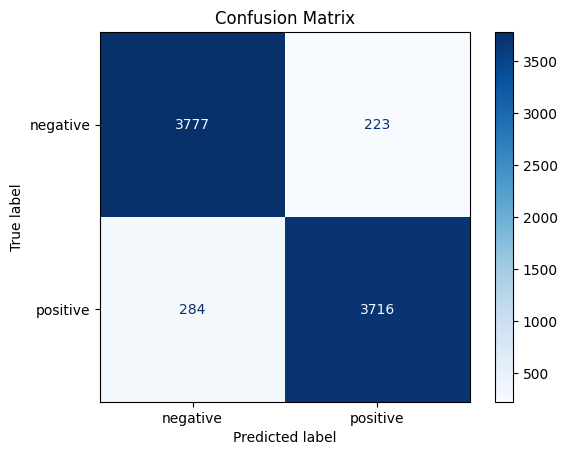

250/250 [==============================] - 1s 2ms/step


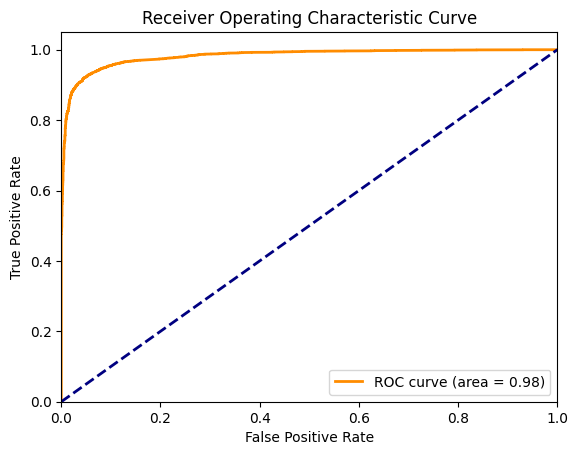

In [4]:
data = np.load('export/model/NNClassifier/data.npz')

# Access the arrays stored in the .npz file
X_train = data['X_train']
X_test = data['X_test']
y_train = data['y_train']
y_test = data['y_test']

evaluate_model(NNClassifier(epochs=10, batch_size=32, lr=0.0001),loaded_model,"NNClassifier",X_train,y_train,X_test,y_test)

## 2. SVM Model

d:\Python310\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


SVM Model Evaluation:

Cross-Validation Scores: [0.8346875 0.8284375 0.825     0.82375   0.8259375 0.8234375 0.83375
 0.835     0.8253125 0.8290625]

Cross-Validation Average Score: 0.83

Accuracy Scores: 0.818625

Classification Report:

precision    recall  f1-score   support

           0       0.79      0.87      0.83      4000
           1       0.86      0.76      0.81      4000

    accuracy                           0.82      8000
   macro avg       0.82      0.82      0.82      8000
weighted avg       0.82      0.82      0.82      8000

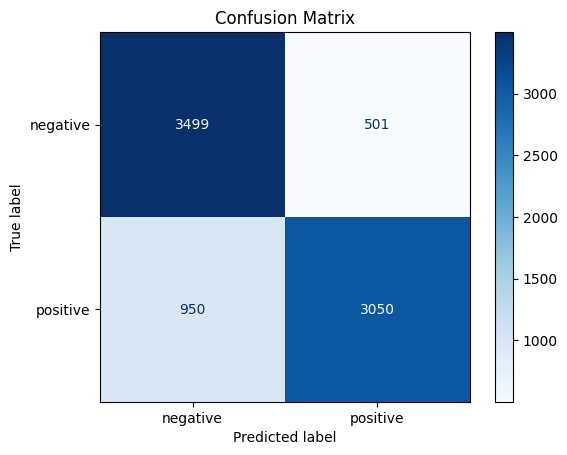

d:\Python310\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


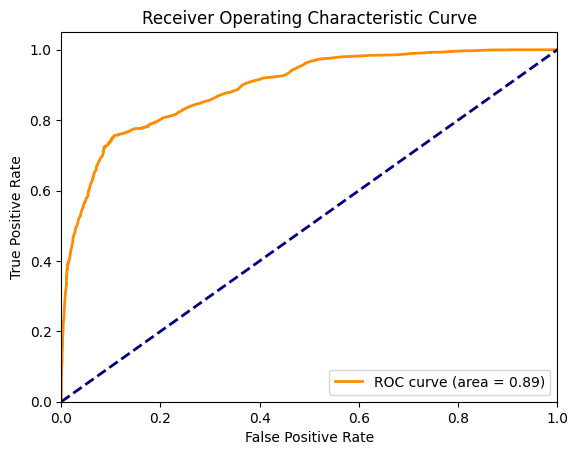

In [5]:
from sklearn.svm import SVC
with open("export/model/SVM/svm_model.dill", "rb") as f:
    svm_model = dill.load(f)
data = np.load('export/model/SVM/data.npz')

# Access the arrays stored in the .npz file
X_train = data['X_train']
X_test = data['X_test']
y_train = data['y_train']
y_test = data['y_test']

evaluate_model(SVC(C = 0.1, kernel='rbf', degree=3, gamma='scale', probability=True),svm_model,"SVM Model",X_train,y_train,X_test,y_test)